# 5.3 基于迁移学习技术的多类别图像检测

## 以端到端模式（使用数据增强技术）下的分类器为例，尝试进行多类别图像分类预测

## 总体思路：将输入图片分割为n张子图片（比如按10x10的网格裁切成100张子图），然后将每一张子图输入到模型中进行分类预测，最后再筛选出所有子图中最接近0和最接近1的图片

## 1. 加载已经训练好的端到端模式下带数据增强技术的分类模型

In [1]:
from keras.models import load_model

In [2]:
classifier = load_model("D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_2_extened_vgg16_with_data_augment.h5")

### 回归一下该分类器结构

In [3]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


## 2 采用10x10的网格对输入图片进行分割

### 2.1 载入多目标类型测试图片

In [4]:
from keras.preprocessing import image
import matplotlib.pyplot as plt 

#指定非洲象图片存储路径
#img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12005.jpg'
img_path2 = 'D:/2-AI读书学习笔记/0-python深度学习/1-dataset_repo/cat_dog_test.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
cat_dog_img = image.load_img(img_path2, target_size = (600,600)) #分割图像时要把原图放大一些
plt.imshow(cat_dog_img)

### 2.2 采样之前，先将图片转换为数组

In [5]:
import numpy as np
def preprocess_img(img):
    x1 = image.img_to_array(img)
    x2 = x1 * 1./255
    x3 = np.expand_dims(x2, axis = 0)
    return x3

In [6]:
cat_dog_array = preprocess_img(cat_dog_img)

### 2.3 执行采样，采样窗口尺寸（150,150），采样步长50
### 累计得到11x11个采样图片，但由于下边框及右边框的图片尺寸不完整，且在本场景中不会影响模型预测，因此丢弃这两个边上的采样图片，故只保留10x10个采样图片

In [12]:
samples = []
for x in range(10):
    for y in range(10):
        samples.append(cat_dog_array[0,x * 50: x * 50 + 150, y * 50: y * 50 + 150,:])

#由list转换为array
samples = np.asarray(samples)

### 2.4 打印采样子图片

In [13]:
fig, axs = plt.subplots(10, 10,figsize = (150,150))

x = 0
for i in range(10):
    for j in range(10):
        axs[i][j].imshow(samples[x])
        x+=1

### 3 使用分类器对图片进行预测


### 3.1 使用训练好的分类器（端到端模式下使用数据增强技术）对采样图片进行逐一预测

#### 随机抽取一张采样图片输入模型进行分类预测

array([[0.90422815]], dtype=float32)

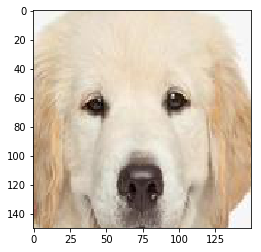

In [9]:
plt.imshow(samples[14])
#特别注意，模型的输入为4维张量，即（批次数，x, y, 3），因此需要为当前输入张量补充一个维度
#另外，输入图片之前已经预处理过，在这里无需再处理
pred = classifier.predict(np.expand_dims(samples[14], axis = 0))
pred

#### 对全部11x11张采样图片进行分类预测

In [14]:
probs = []

for i in range(100):
    pred = classifier.predict(np.expand_dims(samples[i], axis = 0))
    probs.append(pred[0][0])

In [15]:
probs

[0.14602017,
 0.13475536,
 0.281341,
 0.37372,
 0.24419262,
 0.10868197,
 0.13485104,
 0.16905586,
 0.16905586,
 0.16905586,
 0.08371642,
 0.21429788,
 0.71769035,
 0.90422815,
 0.593344,
 0.1489687,
 0.12451591,
 0.16905586,
 0.16905586,
 0.16905586,
 0.11209444,
 0.53668845,
 0.996482,
 0.9927133,
 0.9702506,
 0.19300489,
 0.12528902,
 0.14291404,
 0.17664811,
 0.16863428,
 0.11944188,
 0.32552573,
 0.93475425,
 0.8986983,
 0.76618356,
 0.13923919,
 0.029518165,
 0.034840938,
 0.08097614,
 0.17136312,
 0.115158685,
 0.08377398,
 0.049620137,
 0.052357454,
 0.0738413,
 0.042557627,
 0.0058336854,
 0.0042884317,
 0.02758208,
 0.16474274,
 0.15834594,
 0.17780904,
 0.13382952,
 0.18164301,
 0.09775484,
 0.029742545,
 0.0022801473,
 0.0010536932,
 0.042280447,
 0.12949622,
 0.16247876,
 0.13965932,
 0.090435825,
 0.11247866,
 0.08841961,
 0.09760037,
 0.0029573909,
 0.0023916126,
 0.06766495,
 0.11029144,
 0.15404907,
 0.17081109,
 0.1747287,
 0.25426364,
 0.13652872,
 0.08116831,
 0.028

### 3.2 分析分类预测结果

In [16]:
#找出最接近1的概率
max(probs)

0.996482

In [21]:
#找出最接近1的概率所对应的序号
np.array(probs).argmax()

22

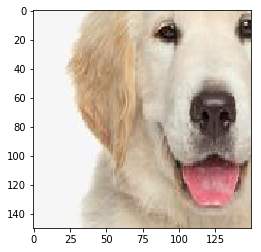

In [22]:
plt.imshow(samples[np.array(probs).argmax()])

#### 即编号22的采样图片最接近狗的分类

#### 最接近猫的图片分类预测概率

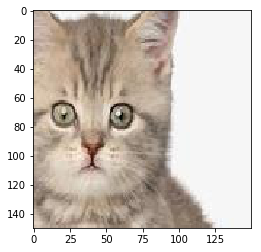

In [23]:
plt.imshow(samples[np.array(probs).argmin()])

In [25]:
min(probs)

0.0010536932

In [24]:
np.array(probs).argmin()

57

#### 编号为57的图片最接近猫